In [1]:
import pandas as pd
import wget
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import root_mean_squared_error
import mlflow
import pickle
# used for OHE
from sklearn.feature_extraction import DictVectorizer
%matplotlib inline

In [2]:
wget.download("https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-01.parquet", "data/green_tripdata_2023-01.parquet")
wget.download("https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-02.parquet", "data/green_tripdata_2023-02.parquet")
wget.download("https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-03.parquet", "data/green_tripdata_2023-03.parquet")

'data/green_tripdata_2023-03.parquet'

In [2]:
# set up mlflow for the project
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("first-experiment")

<Experiment: artifact_location='file:///c:/Users/user/Desktop/mlops-zoom/homework-2/mlruns/1', creation_time=1716848740814, experiment_id='1', last_update_time=1716848740814, lifecycle_stage='active', name='first-experiment', tags={}>

In [3]:
df = pd.read_parquet('data/green_tripdata_2023-01.parquet')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68211 entries, 0 to 68210
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               68211 non-null  int64         
 1   lpep_pickup_datetime   68211 non-null  datetime64[us]
 2   lpep_dropoff_datetime  68211 non-null  datetime64[us]
 3   store_and_fwd_flag     63887 non-null  object        
 4   RatecodeID             63887 non-null  float64       
 5   PULocationID           68211 non-null  int64         
 6   DOLocationID           68211 non-null  int64         
 7   passenger_count        63887 non-null  float64       
 8   trip_distance          68211 non-null  float64       
 9   fare_amount            68211 non-null  float64       
 10  extra                  68211 non-null  float64       
 11  mta_tax                68211 non-null  float64       
 12  tip_amount             68211 non-null  float64       
 13  t

In [4]:
df["duration"] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda date: date.total_seconds() / 60)
df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype('str')

In [5]:
train_data = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_data)

y_train = df.duration.values

In [6]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

7.0603515317164085

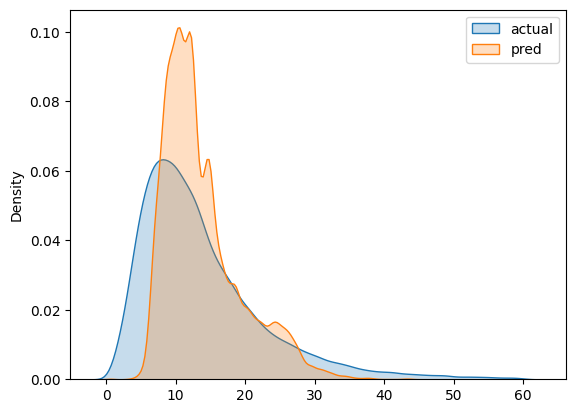

In [7]:
# check distribution
sns.kdeplot(y_train, label='actual', fill=True)
sns.kdeplot(y_pred, label='pred', fill=True)
plt.legend()
plt.show()

In [8]:
def read_df(filename):
    df = pd.read_parquet(filename)
    
    df["duration"] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda date: date.total_seconds() / 60)
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    
    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype('str')
    
    return df   

In [9]:
train = read_df("data/green_tripdata_2023-01.parquet")
val = read_df("data/green_tripdata_2023-02.parquet")

train.shape, val.shape

((65946, 21), (62574, 21))

In [10]:
# feature engineering
train["PU_DO"] = train["PULocationID"] + "_" + train["DOLocationID"]
val["PU_DO"] = val["PULocationID"] + "_" + val["DOLocationID"]

In [11]:
categorical = ["PU_DO"]
numerical = ["trip_distance"]

dv = DictVectorizer()

train_dicts = train[categorical + numerical].to_dict(orient = "records")
X_train = dv.fit_transform(train_dicts)

val_dicts = val[categorical + numerical].to_dict(orient = "records")
X_val = dv.transform(val_dicts)

In [12]:
y_train = train.duration.values
y_val = val.duration.values

In [13]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

6.037713760833734

In [14]:
# save the model
!mkdir models

with open("models/lin_reg.bin", 'wb') as file:
    pickle.dump((dv, lr), file)

In [14]:
# say we're using lasso, we keep track with mlflow
with mlflow.start_run():
    
    # metadata
    mlflow.set_tag("developer", "stephen")
    
    # parameters
    mlflow.log_param("train-data-path", "./data/green_tripdata_2023-01.parquet")
    mlflow.log_param("valid-data-path", "./data/green_tripdata_2023-02.parquet")

    alpha = 0.1
    mlflow.log_param("alpha", alpha)
        
    model = Lasso(alpha)
    model.fit(X_train, y_train)

    preds = model.predict(X_val)
    rmse = root_mean_squared_error(y_val, preds)
    print("RMSE:", rmse)
    
    # metrics
    mlflow.log_metric("rmse", rmse)

RMSE: 9.242491841499588


# XGBoost

In [14]:
import xgboost as xgb
# used for hyperparameter tuning
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [15]:
# create data stuctures for xgboost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

In [18]:
# function to run to optimize the hyperparameters
def objective(params):
    with mlflow.start_run():
        # set model
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        
        # create xgboost model
        xgb_model = xgb.train(
            params = params,
            dtrain = dtrain,
            num_boost_round=1000,
            evals=[(dval, "validation")],
            early_stopping_rounds = 50
        )
        
        # predict and calculate metric
        preds = xgb_model.predict(dval)
        rmse = root_mean_squared_error(y_val, preds)
        
        # log rmse
        mlflow.log_metric("rmse", rmse)
    
    return {'loss': rmse, 'status': STATUS_OK}

In [21]:
# search space for hyperparameters
param_space = {
    "objective": 'reg:sqaurederror',
    "seed": 42,
    "max_depth": scope.int(hp.quniform("max_depth", 3, 100, 1)),
    "learning_rate": hp.loguniform("learning_rate", -3, 0),
    "reg_alpha": hp.loguniform("reg_alpha", -5, 1),
    "reg_lambda": hp.loguniform("reg_lambda", -5, 1),
    "min_child_weight": hp.loguniform("min_child_weight", -1, 3),
}

# start the search for best hyperparameters
best_results = fmin(
    fn=objective,
    space=param_space,
    algo = tpe.suggest, #algo to use
    max_evals=50,
    trials = Trials() # store results
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:12:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.51444                           
[1]	validation-rmse:5.29448                           
[2]	validation-rmse:5.25272                           
[3]	validation-rmse:5.24353                           
[4]	validation-rmse:5.22432                           
[5]	validation-rmse:5.22109                           
[6]	validation-rmse:5.21663                           
[7]	validation-rmse:5.21436                           
[8]	validation-rmse:5.21121                           
[9]	validation-rmse:5.21110                           
[10]	validation-rmse:5.20974                          
[11]	validation-rmse:5.20900                          
[12]	validation-rmse:5.20782                          
[13]	validation-rmse:5.20640                          
[14]	validation-rmse:5.20532                          
[15]	validation-rmse:5.20325                          
[16]	validation-rmse:5.19979                          
[17]	validation-rmse:5.20174                          
[18]	valid

c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:12:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.56989                                                   
[1]	validation-rmse:5.65800                                                   
[2]	validation-rmse:5.38620                                                   
[3]	validation-rmse:5.29039                                                   
[4]	validation-rmse:5.24809                                                   
[5]	validation-rmse:5.22776                                                   
[6]	validation-rmse:5.21678                                                   
[7]	validation-rmse:5.21116                                                   
[8]	validation-rmse:5.20825                                                   
[9]	validation-rmse:5.20114                                                   
[10]	validation-rmse:5.19469                                                  
[11]	validation-rmse:5.19417                                                  
[12]	validation-rmse:5.19326                        

c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:13:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.16531                                                    
[1]	validation-rmse:7.30541                                                    
[2]	validation-rmse:6.67777                                                    
[3]	validation-rmse:6.23022                                                    
[4]	validation-rmse:5.92115                                                    
[5]	validation-rmse:5.70762                                                    
[6]	validation-rmse:5.54852                                                    
[7]	validation-rmse:5.45563                                                    
[8]	validation-rmse:5.38982                                                    
[9]	validation-rmse:5.33978                                                    
[10]	validation-rmse:5.30909                                                   
[11]	validation-rmse:5.28363                                                   
[12]	validation-rmse:5.26054            

c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:14:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.19819                                                    
[1]	validation-rmse:6.17687                                                    
[2]	validation-rmse:5.71429                                                    
[3]	validation-rmse:5.51412                                                    
[4]	validation-rmse:5.41239                                                    
[5]	validation-rmse:5.36280                                                    
[6]	validation-rmse:5.33481                                                    
[7]	validation-rmse:5.31613                                                    
[8]	validation-rmse:5.30365                                                    
[9]	validation-rmse:5.29712                                                    
[10]	validation-rmse:5.29333                                                   
[11]	validation-rmse:5.29032                                                   
[12]	validation-rmse:5.28577            

c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:14:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.18560                                                    
[1]	validation-rmse:7.33665                                                    
[2]	validation-rmse:6.71885                                                    
[3]	validation-rmse:6.27304                                                    
[4]	validation-rmse:5.95587                                                    
[5]	validation-rmse:5.73461                                                    
[6]	validation-rmse:5.58318                                                    
[7]	validation-rmse:5.47140                                                    
[8]	validation-rmse:5.39494                                                    
[9]	validation-rmse:5.34069                                                    
[10]	validation-rmse:5.30494                                                   
[11]	validation-rmse:5.27359                                                   
[12]	validation-rmse:5.25231            

c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:15:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:5.51892                                                    
[4]	validation-rmse:5.51081                                                    
[5]	validation-rmse:5.50448                                                    
[6]	validation-rmse:5.49700                                                    
[7]	validation-rmse:5.49213                                                    
[8]	validation-rmse:5.48222                                                    
[9]	validation-rmse:5.46907                                                    
[10]	validation-rmse:5.44876                                                   
[11]	validation-rmse:5.44278                                                   
[12]	validation-rmse:5.42617                                                   
[13]	validation-rmse:5.41724                                                   
[14]	validation-rmse:5.41105                                                   
[15]	validation-rmse:5.40363            

c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:15:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.80905                                                    
[1]	validation-rmse:8.35431                                                    
[2]	validation-rmse:7.94672                                                    
[3]	validation-rmse:7.59453                                                    
[4]	validation-rmse:7.28082                                                    
[5]	validation-rmse:7.00579                                                    
[6]	validation-rmse:6.76779                                                    
[7]	validation-rmse:6.56385                                                    
[8]	validation-rmse:6.37978                                                    
[9]	validation-rmse:6.22213                                                    
[10]	validation-rmse:6.09411                                                   
[11]	validation-rmse:5.97313                                                   
[12]	validation-rmse:5.87473            

c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:18:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.37702                                                    
[1]	validation-rmse:6.30607                                                    
[2]	validation-rmse:5.75204                                                    
[3]	validation-rmse:5.48116                                                    
[4]	validation-rmse:5.34793                                                    
[5]	validation-rmse:5.28029                                                    
[6]	validation-rmse:5.24161                                                    
[7]	validation-rmse:5.22108                                                    
[8]	validation-rmse:5.21215                                                    
[9]	validation-rmse:5.20111                                                    
[10]	validation-rmse:5.19239                                                   
[11]	validation-rmse:5.18606                                                   
[12]	validation-rmse:5.18276            

c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:19:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.92697                                                    
[1]	validation-rmse:8.56401                                                    
[2]	validation-rmse:8.23169                                                    
[3]	validation-rmse:7.92662                                                    
[4]	validation-rmse:7.64850                                                    
[5]	validation-rmse:7.39460                                                    
[6]	validation-rmse:7.16392                                                    
[7]	validation-rmse:6.95438                                                    
[8]	validation-rmse:6.76514                                                    
[9]	validation-rmse:6.59318                                                    
[10]	validation-rmse:6.43920                                                   
[11]	validation-rmse:6.30020                                                   
[12]	validation-rmse:6.17620            

c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:21:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.56185                                                      
[1]	validation-rmse:6.54684                                                      
[2]	validation-rmse:5.99271                                                      
[3]	validation-rmse:5.69852                                                      
[4]	validation-rmse:5.54102                                                      
[5]	validation-rmse:5.45507                                                      
[6]	validation-rmse:5.40234                                                      
[7]	validation-rmse:5.36863                                                      
[8]	validation-rmse:5.34795                                                      
[9]	validation-rmse:5.33186                                                      
[10]	validation-rmse:5.32226                                                     
[11]	validation-rmse:5.31436                                                     
[12]	validation-

c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:23:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.67162                                                     
[1]	validation-rmse:5.69637                                                     
[2]	validation-rmse:5.37879                                                     
[3]	validation-rmse:5.27090                                                     
[4]	validation-rmse:5.22470                                                     
[5]	validation-rmse:5.20875                                                     
[6]	validation-rmse:5.19796                                                     
[7]	validation-rmse:5.18047                                                     
[8]	validation-rmse:5.17742                                                     
[9]	validation-rmse:5.17158                                                     
[10]	validation-rmse:5.16951                                                    
[11]	validation-rmse:5.16773                                                    
[12]	validation-rmse:5.17045

c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:23:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.83656                                                     
[1]	validation-rmse:8.40338                                                     
[2]	validation-rmse:8.01826                                                     
[3]	validation-rmse:7.67701                                                     
[4]	validation-rmse:7.37531                                                     
[5]	validation-rmse:7.10975                                                     
[6]	validation-rmse:6.87643                                                     
[7]	validation-rmse:6.67212                                                     
[8]	validation-rmse:6.49421                                                     
[9]	validation-rmse:6.33851                                                     
[10]	validation-rmse:6.20253                                                    
[11]	validation-rmse:6.08466                                                    
[12]	validation-rmse:5.98285

c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:25:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.70210                                                     
[1]	validation-rmse:5.38130                                                     
[2]	validation-rmse:5.32019                                                     
[3]	validation-rmse:5.29665                                                     
[4]	validation-rmse:5.27767                                                     
[5]	validation-rmse:5.26223                                                     
[6]	validation-rmse:5.25974                                                     
[7]	validation-rmse:5.25061                                                     
[8]	validation-rmse:5.25160                                                     
[9]	validation-rmse:5.24447                                                     
[10]	validation-rmse:5.24329                                                    
[11]	validation-rmse:5.24212                                                    
[12]	validation-rmse:5.23931

c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:26:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.41844                                                     
[1]	validation-rmse:5.56742                                                     
[2]	validation-rmse:5.33973                                                     
[3]	validation-rmse:5.26711                                                     
[4]	validation-rmse:5.23634                                                     
[5]	validation-rmse:5.22599                                                     
[6]	validation-rmse:5.22272                                                     
[7]	validation-rmse:5.21681                                                     
[8]	validation-rmse:5.21384                                                     
[9]	validation-rmse:5.21006                                                     
[10]	validation-rmse:5.20668                                                    
[11]	validation-rmse:5.20150                                                    
[12]	validation-rmse:5.19783

c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:26:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.64891                                                     
[1]	validation-rmse:5.61972                                                     
[2]	validation-rmse:5.30934                                                     
[3]	validation-rmse:5.23264                                                     
[4]	validation-rmse:5.18978                                                     
[5]	validation-rmse:5.18766                                                     
[6]	validation-rmse:5.18409                                                     
[7]	validation-rmse:5.17389                                                     
[8]	validation-rmse:5.17997                                                     
[9]	validation-rmse:5.17954                                                     
[10]	validation-rmse:5.17116                                                    
[11]	validation-rmse:5.17512                                                    
[12]	validation-rmse:5.17592

c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:27:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:6.15700                                                     
[2]	validation-rmse:5.72892                                                     
[3]	validation-rmse:5.54370                                                     
[4]	validation-rmse:5.44980                                                     
[5]	validation-rmse:5.40088                                                     
[6]	validation-rmse:5.38113                                                     
[7]	validation-rmse:5.36378                                                     
[8]	validation-rmse:5.35505                                                     
[9]	validation-rmse:5.35030                                                     
[10]	validation-rmse:5.34833                                                    
[11]	validation-rmse:5.34528                                                    
[12]	validation-rmse:5.34161                                                    
[13]	validation-rmse:5.33799

c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:27:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.70863                                                     
[1]	validation-rmse:5.76135                                                     
[2]	validation-rmse:5.46096                                                     
[3]	validation-rmse:5.36776                                                     
[4]	validation-rmse:5.30457                                                     
[5]	validation-rmse:5.30000                                                     
[6]	validation-rmse:5.29545                                                     
[7]	validation-rmse:5.29339                                                     
[8]	validation-rmse:5.28293                                                     
[9]	validation-rmse:5.27872                                                     
[10]	validation-rmse:5.27452                                                    
[11]	validation-rmse:5.27218                                                    
[12]	validation-rmse:5.27445

c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:28:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.47405                                                     
[1]	validation-rmse:6.40782                                                     
[2]	validation-rmse:5.84986                                                     
[3]	validation-rmse:5.54161                                                     
[4]	validation-rmse:5.38413                                                     
[5]	validation-rmse:5.31477                                                     
[6]	validation-rmse:5.27571                                                     
[7]	validation-rmse:5.24317                                                     
[8]	validation-rmse:5.22937                                                     
[9]	validation-rmse:5.22033                                                     
[10]	validation-rmse:5.20718                                                    
[11]	validation-rmse:5.20526                                                    
[12]	validation-rmse:5.20321

c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:28:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.99686                                                     
[1]	validation-rmse:5.93472                                                     
[2]	validation-rmse:5.49234                                                     
[3]	validation-rmse:5.30972                                                     
[4]	validation-rmse:5.23268                                                     
[5]	validation-rmse:5.19959                                                     
[6]	validation-rmse:5.18435                                                     
[7]	validation-rmse:5.17792                                                     
[8]	validation-rmse:5.17288                                                     
[9]	validation-rmse:5.16879                                                     
[10]	validation-rmse:5.16412                                                    
[11]	validation-rmse:5.16479                                                    
[12]	validation-rmse:5.16332

c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:29:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.39847                                                     
[1]	validation-rmse:5.24185                                                     
[2]	validation-rmse:5.22229                                                     
[3]	validation-rmse:5.22109                                                     
[4]	validation-rmse:5.21630                                                     
[5]	validation-rmse:5.21562                                                     
[6]	validation-rmse:5.21386                                                     
[7]	validation-rmse:5.21475                                                     
[8]	validation-rmse:5.21281                                                     
[9]	validation-rmse:5.21419                                                     
[10]	validation-rmse:5.21023                                                    
[11]	validation-rmse:5.21147                                                    
[12]	validation-rmse:5.21197

c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:29:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.94359                                                     
[1]	validation-rmse:7.00307                                                     
[2]	validation-rmse:6.38006                                                     
[3]	validation-rmse:5.97661                                                     
[4]	validation-rmse:5.71783                                                     
[5]	validation-rmse:5.55533                                                     
[6]	validation-rmse:5.44988                                                     
[7]	validation-rmse:5.38139                                                     
[8]	validation-rmse:5.33622                                                     
[9]	validation-rmse:5.30504                                                     
[10]	validation-rmse:5.28479                                                    
[11]	validation-rmse:5.26604                                                    
[12]	validation-rmse:5.25285

c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:30:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.58685                                                     
[1]	validation-rmse:7.97434                                                     
[2]	validation-rmse:7.47010                                                     
[3]	validation-rmse:7.05526                                                     
[4]	validation-rmse:6.71590                                                     
[5]	validation-rmse:6.44109                                                     
[6]	validation-rmse:6.22023                                                     
[7]	validation-rmse:6.03665                                                     
[8]	validation-rmse:5.89420                                                     
[9]	validation-rmse:5.77729                                                     
[10]	validation-rmse:5.68405                                                    
[11]	validation-rmse:5.61066                                                    
[12]	validation-rmse:5.55316

c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:31:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.91229                                                     
[1]	validation-rmse:6.98025                                                     
[2]	validation-rmse:6.38367                                                     
[3]	validation-rmse:6.01204                                                     
[4]	validation-rmse:5.78639                                                     
[5]	validation-rmse:5.64734                                                     
[6]	validation-rmse:5.56293                                                     
[7]	validation-rmse:5.50847                                                     
[8]	validation-rmse:5.46993                                                     
[9]	validation-rmse:5.44394                                                     
[10]	validation-rmse:5.42383                                                    
[11]	validation-rmse:5.40824                                                    
[12]	validation-rmse:5.39555

c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:32:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.50685                                                     
[1]	validation-rmse:7.84571                                                     
[2]	validation-rmse:7.31226                                                     
[3]	validation-rmse:6.88743                                                     
[4]	validation-rmse:6.55204                                                     
[5]	validation-rmse:6.28897                                                     
[6]	validation-rmse:6.07612                                                     
[7]	validation-rmse:5.91206                                                     
[8]	validation-rmse:5.78541                                                     
[9]	validation-rmse:5.68640                                                     
[10]	validation-rmse:5.61247                                                    
[11]	validation-rmse:5.54943                                                    
[12]	validation-rmse:5.50043

c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:33:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.93376                                                     
[1]	validation-rmse:6.98656                                                     
[2]	validation-rmse:6.35493                                                     
[3]	validation-rmse:5.94574                                                     
[4]	validation-rmse:5.68032                                                     
[5]	validation-rmse:5.51245                                                     
[6]	validation-rmse:5.40419                                                     
[7]	validation-rmse:5.33295                                                     
[8]	validation-rmse:5.28729                                                     
[9]	validation-rmse:5.25714                                                     
[10]	validation-rmse:5.23655                                                    
[11]	validation-rmse:5.22325                                                    
[12]	validation-rmse:5.21386

c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:34:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.99793                                                     
[1]	validation-rmse:5.38016                                                     
[2]	validation-rmse:5.26805                                                     
[3]	validation-rmse:5.23034                                                     
[4]	validation-rmse:5.22367                                                     
[5]	validation-rmse:5.21915                                                     
[6]	validation-rmse:5.20992                                                     
[7]	validation-rmse:5.19652                                                     
[8]	validation-rmse:5.19496                                                     
[9]	validation-rmse:5.18720                                                     
[10]	validation-rmse:5.18553                                                    
[11]	validation-rmse:5.18173                                                    
[12]	validation-rmse:5.17813

c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:34:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[7]	validation-rmse:6.15597                                                     
[8]	validation-rmse:6.03480                                                     
[9]	validation-rmse:5.94232                                                     
[10]	validation-rmse:5.86909                                                    
[11]	validation-rmse:5.81361                                                    
[12]	validation-rmse:5.76903                                                    
[13]	validation-rmse:5.73238                                                    
[14]	validation-rmse:5.70461                                                    
[15]	validation-rmse:5.68115                                                    
[16]	validation-rmse:5.66437                                                    
[17]	validation-rmse:5.65018                                                    
[18]	validation-rmse:5.63637                                                    
[19]	validation-rmse:5.62683

c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:35:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.17780                                                     
[1]	validation-rmse:7.32146                                                     
[2]	validation-rmse:6.69541                                                     
[3]	validation-rmse:6.24513                                                     
[4]	validation-rmse:5.92541                                                     
[5]	validation-rmse:5.69908                                                     
[6]	validation-rmse:5.54029                                                     
[7]	validation-rmse:5.43113                                                     
[8]	validation-rmse:5.35491                                                     
[9]	validation-rmse:5.30005                                                     
[10]	validation-rmse:5.26328                                                    
[11]	validation-rmse:5.23864                                                    
[12]	validation-rmse:5.21887

c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:36:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.29708                                                     
[1]	validation-rmse:7.51756                                                     
[2]	validation-rmse:6.93358                                                     
[3]	validation-rmse:6.50082                                                     
[4]	validation-rmse:6.18581                                                     
[5]	validation-rmse:5.96047                                                     
[6]	validation-rmse:5.79963                                                     
[7]	validation-rmse:5.68395                                                     
[8]	validation-rmse:5.59938                                                     
[9]	validation-rmse:5.54000                                                     
[10]	validation-rmse:5.49753                                                    
[11]	validation-rmse:5.46248                                                    
[12]	validation-rmse:5.43300

c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:37:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.77451                                                     
[1]	validation-rmse:8.29143                                                     
[2]	validation-rmse:7.86686                                                     
[3]	validation-rmse:7.49549                                                     
[4]	validation-rmse:7.17162                                                     
[5]	validation-rmse:6.89059                                                     
[6]	validation-rmse:6.64753                                                     
[7]	validation-rmse:6.43785                                                     
[8]	validation-rmse:6.25753                                                     
[9]	validation-rmse:6.10295                                                     
[10]	validation-rmse:5.97117                                                    
[11]	validation-rmse:5.85826                                                    
[12]	validation-rmse:5.76259

c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:38:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.99485                                                     
[1]	validation-rmse:8.69018                                                     
[2]	validation-rmse:8.40667                                                     
[3]	validation-rmse:8.14389                                                     
[4]	validation-rmse:7.90071                                                     
[5]	validation-rmse:7.67543                                                     
[6]	validation-rmse:7.46643                                                     
[7]	validation-rmse:7.27511                                                     
[8]	validation-rmse:7.09758                                                     
[9]	validation-rmse:6.93407                                                     
[10]	validation-rmse:6.78352                                                    
[11]	validation-rmse:6.64571                                                    
[12]	validation-rmse:6.51825

c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:41:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.73817                                                     
[1]	validation-rmse:8.22956                                                     
[2]	validation-rmse:7.78760                                                     
[3]	validation-rmse:7.40590                                                     
[4]	validation-rmse:7.07767                                                     
[5]	validation-rmse:6.79686                                                     
[6]	validation-rmse:6.55716                                                     
[7]	validation-rmse:6.35438                                                     
[8]	validation-rmse:6.18330                                                     
[9]	validation-rmse:6.03900                                                     
[10]	validation-rmse:5.91716                                                    
[11]	validation-rmse:5.81495                                                    
[12]	validation-rmse:5.72981

c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:43:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.67088                                                      
[1]	validation-rmse:8.11297                                                      
[2]	validation-rmse:7.63763                                                      
[3]	validation-rmse:7.23385                                                      
[4]	validation-rmse:6.89346                                                      
[5]	validation-rmse:6.60853                                                      
[6]	validation-rmse:6.37066                                                      
[7]	validation-rmse:6.17301                                                      
[8]	validation-rmse:6.01031                                                      
[9]	validation-rmse:5.87577                                                      
[10]	validation-rmse:5.76533                                                     
[11]	validation-rmse:5.67461                                                     
[12]	validation-

c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:45:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.86859                                                     
[1]	validation-rmse:8.45932                                                     
[2]	validation-rmse:8.09150                                                     
[3]	validation-rmse:7.76107                                                     
[4]	validation-rmse:7.46498                                                     
[5]	validation-rmse:7.20115                                                     
[6]	validation-rmse:6.96561                                                     
[7]	validation-rmse:6.75651                                                     
[8]	validation-rmse:6.57176                                                     
[9]	validation-rmse:6.40662                                                     
[10]	validation-rmse:6.26151                                                    
[11]	validation-rmse:6.13347                                                    
[12]	validation-rmse:6.02051

c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:46:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.90788                                                     
[1]	validation-rmse:8.53111                                                     
[2]	validation-rmse:8.18895                                                     
[3]	validation-rmse:7.87746                                                     
[4]	validation-rmse:7.59679                                                     
[5]	validation-rmse:7.34352                                                     
[6]	validation-rmse:7.11436                                                     
[7]	validation-rmse:6.90847                                                     
[8]	validation-rmse:6.72268                                                     
[9]	validation-rmse:6.55573                                                     
[10]	validation-rmse:6.40621                                                    
[11]	validation-rmse:6.27168                                                    
[12]	validation-rmse:6.15461

c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:48:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.89410                                                     
[1]	validation-rmse:8.50583                                                     
[2]	validation-rmse:8.15411                                                     
[3]	validation-rmse:7.83593                                                     
[4]	validation-rmse:7.54953                                                     
[5]	validation-rmse:7.29149                                                     
[6]	validation-rmse:7.05962                                                     
[7]	validation-rmse:6.85151                                                     
[8]	validation-rmse:6.66654                                                     
[9]	validation-rmse:6.49903                                                     
[10]	validation-rmse:6.35059                                                    
[11]	validation-rmse:6.21788                                                    
[12]	validation-rmse:6.10111

c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:49:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.98671                                                     
[1]	validation-rmse:8.67691                                                     
[2]	validation-rmse:8.38745                                                     
[3]	validation-rmse:8.12150                                                     
[4]	validation-rmse:7.87684                                                     
[5]	validation-rmse:7.64945                                                     
[6]	validation-rmse:7.44040                                                     
[7]	validation-rmse:7.24950                                                     
[8]	validation-rmse:7.07332                                                     
[9]	validation-rmse:6.91033                                                     
[10]	validation-rmse:6.76253                                                    
[11]	validation-rmse:6.62356                                                    
[12]	validation-rmse:6.50240

c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:52:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.88964                                                      
[1]	validation-rmse:8.49762                                                      
[2]	validation-rmse:8.14440                                                      
[3]	validation-rmse:7.82417                                                      
[4]	validation-rmse:7.53793                                                      
[5]	validation-rmse:7.27968                                                      
[6]	validation-rmse:7.04625                                                      
[7]	validation-rmse:6.84107                                                      
[8]	validation-rmse:6.65620                                                      
[9]	validation-rmse:6.48890                                                      
[10]	validation-rmse:6.34311                                                     
[11]	validation-rmse:6.21115                                                     
[12]	validation-

c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:54:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.65905                                                      
[1]	validation-rmse:8.09289                                                      
[2]	validation-rmse:7.61061                                                      
[3]	validation-rmse:7.20482                                                      
[4]	validation-rmse:6.86160                                                      
[5]	validation-rmse:6.57836                                                      
[6]	validation-rmse:6.33546                                                      
[7]	validation-rmse:6.14161                                                      
[8]	validation-rmse:5.97431                                                      
[9]	validation-rmse:5.83720                                                      
[10]	validation-rmse:5.72897                                                     
[11]	validation-rmse:5.63546                                                     
[12]	validation-

c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:55:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.39451                                                      
[1]	validation-rmse:7.66760                                                      
[2]	validation-rmse:7.10559                                                      
[3]	validation-rmse:6.68104                                                      
[4]	validation-rmse:6.35788                                                      
[5]	validation-rmse:6.11283                                                      
[6]	validation-rmse:5.93731                                                      
[7]	validation-rmse:5.80318                                                      
[8]	validation-rmse:5.70460                                                      
[9]	validation-rmse:5.62656                                                      
[10]	validation-rmse:5.57062                                                     
[11]	validation-rmse:5.52862                                                     
[12]	validation-

c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:56:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.01573                                                     
[1]	validation-rmse:8.73063                                                     
[2]	validation-rmse:8.46452                                                     
[3]	validation-rmse:8.21822                                                     
[4]	validation-rmse:7.98868                                                     
[5]	validation-rmse:7.77611                                                     
[6]	validation-rmse:7.58033                                                     
[7]	validation-rmse:7.39721                                                     
[8]	validation-rmse:7.22995                                                     
[9]	validation-rmse:7.07310                                                     
[10]	validation-rmse:6.93139                                                    
[11]	validation-rmse:6.79902                                                    
[12]	validation-rmse:6.67588

c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:58:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.85602                                                     
[1]	validation-rmse:8.43767                                                     
[2]	validation-rmse:8.06244                                                     
[3]	validation-rmse:7.72668                                                     
[4]	validation-rmse:7.42677                                                     
[5]	validation-rmse:7.16056                                                     
[6]	validation-rmse:6.92421                                                     
[7]	validation-rmse:6.71543                                                     
[8]	validation-rmse:6.53159                                                     
[9]	validation-rmse:6.36981                                                     
[10]	validation-rmse:6.22767                                                    
[11]	validation-rmse:6.10344                                                    
[12]	validation-rmse:5.99460

c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:00:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.95184                                                      
[1]	validation-rmse:8.61078                                                      
[2]	validation-rmse:8.29771                                                      
[3]	validation-rmse:8.01057                                                      
[4]	validation-rmse:7.74736                                                      
[5]	validation-rmse:7.50669                                                      
[6]	validation-rmse:7.28696                                                      
[7]	validation-rmse:7.08666                                                      
[8]	validation-rmse:6.90416                                                      
[9]	validation-rmse:6.73857                                                      
[10]	validation-rmse:6.58798                                                     
[11]	validation-rmse:6.45196                                                     
[12]	validation-

c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:02:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.75133                                                      
[1]	validation-rmse:8.25312                                                      
[2]	validation-rmse:7.81771                                                      
[3]	validation-rmse:7.44247                                                      
[4]	validation-rmse:7.11614                                                      
[5]	validation-rmse:6.83669                                                      
[6]	validation-rmse:6.59641                                                      
[7]	validation-rmse:6.39057                                                      
[8]	validation-rmse:6.21535                                                      
[9]	validation-rmse:6.06753                                                      
[10]	validation-rmse:5.94003                                                     
[11]	validation-rmse:5.83402                                                     
[12]	validation-

c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:04:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.94451                                                      
[1]	validation-rmse:8.59860                                                      
[2]	validation-rmse:8.28220                                                      
[3]	validation-rmse:7.99366                                                      
[4]	validation-rmse:7.73128                                                      
[5]	validation-rmse:7.49248                                                      
[6]	validation-rmse:7.27572                                                      
[7]	validation-rmse:7.07973                                                      
[8]	validation-rmse:6.90219                                                      
[9]	validation-rmse:6.74183                                                      
[10]	validation-rmse:6.59760                                                     
[11]	validation-rmse:6.46725                                                     
[12]	validation-

c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:06:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.63926                                                      
[1]	validation-rmse:8.05843                                                      
[2]	validation-rmse:7.56649                                                      
[3]	validation-rmse:7.15282                                                      
[4]	validation-rmse:6.80773                                                      
[5]	validation-rmse:6.52194                                                      
[6]	validation-rmse:6.28488                                                      
[7]	validation-rmse:6.09009                                                      
[8]	validation-rmse:5.93130                                                      
[9]	validation-rmse:5.80151                                                      
[10]	validation-rmse:5.69566                                                     
[11]	validation-rmse:5.61024                                                     
[12]	validation-

c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:08:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.85338                                                      
[1]	validation-rmse:8.43416                                                      
[2]	validation-rmse:8.06034                                                      
[3]	validation-rmse:7.72805                                                      
[4]	validation-rmse:7.43350                                                      
[5]	validation-rmse:7.17322                                                      
[6]	validation-rmse:6.94349                                                      
[7]	validation-rmse:6.74118                                                      
[8]	validation-rmse:6.56402                                                      
[9]	validation-rmse:6.40913                                                      
[10]	validation-rmse:6.27329                                                     
[11]	validation-rmse:6.15522                                                     
[12]	validation-

c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:10:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.30133                                                      
[1]	validation-rmse:5.29175                                                      
[2]	validation-rmse:5.28925                                                      
[3]	validation-rmse:5.28461                                                      
[4]	validation-rmse:5.28602                                                      
[5]	validation-rmse:5.28604                                                      
[6]	validation-rmse:5.28201                                                      
[7]	validation-rmse:5.27618                                                      
[8]	validation-rmse:5.25130                                                      
[9]	validation-rmse:5.24674                                                      
[10]	validation-rmse:5.24373                                                     
[11]	validation-rmse:5.24073                                                     
[12]	validation-

c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:11:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.13006                                                     
[1]	validation-rmse:7.27532                                                     
[2]	validation-rmse:6.67674                                                     
[3]	validation-rmse:6.26278                                                     
[4]	validation-rmse:5.98469                                                     
[5]	validation-rmse:5.79872                                                     
[6]	validation-rmse:5.67126                                                     
[7]	validation-rmse:5.58028                                                     
[8]	validation-rmse:5.51771                                                     
[9]	validation-rmse:5.47516                                                     
[10]	validation-rmse:5.44325                                                    
[11]	validation-rmse:5.42033                                                    
[12]	validation-rmse:5.40416

c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:12:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.39493                                                     
[1]	validation-rmse:7.65704                                                     
[2]	validation-rmse:7.07869                                                     
[3]	validation-rmse:6.63189                                                     
[4]	validation-rmse:6.28758                                                     
[5]	validation-rmse:6.02505                                                     
[6]	validation-rmse:5.82687                                                     
[7]	validation-rmse:5.67756                                                     
[8]	validation-rmse:5.56487                                                     
[9]	validation-rmse:5.47911                                                     
[10]	validation-rmse:5.41558                                                    
[11]	validation-rmse:5.36770                                                    
[12]	validation-rmse:5.33028

In [23]:
# best params from mlflow interface
best_params = {
    "objective": 'reg:linear', #reg:squarederror
    "seed": 42,
    "max_depth": 37,
    "learning_rate": 0.07357193210381406,
    "reg_alpha": 2.634654040828939,
    "reg_lambda": 0.00855873726543807,
    "min_child_weight": 3.8973588565538324,
}

# train the 'best' model using autolog
mlflow.xgboost.autolog()

xgb_model = xgb.train(
    params = best_params,
    dtrain = dtrain,
    num_boost_round=1000,
    evals=[(dval, "validation")],
    early_stopping_rounds = 50
)


2024/05/29 15:37:42 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '798c91246fa54560b53d5cc847948001', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [15:37:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:8.86859
[1]	validation-rmse:8.45932
[2]	validation-rmse:8.09150
[3]	validation-rmse:7.76107
[4]	validation-rmse:7.46498
[5]	validation-rmse:7.20115
[6]	validation-rmse:6.96561
[7]	validation-rmse:6.75651
[8]	validation-rmse:6.57176
[9]	validation-rmse:6.40662
[10]	validation-rmse:6.26151
[11]	validation-rmse:6.13347
[12]	validation-rmse:6.02051
[13]	validation-rmse:5.92065
[14]	validation-rmse:5.83230
[15]	validation-rmse:5.75530
[16]	validation-rmse:5.68645
[17]	validation-rmse:5.62705
[18]	validation-rmse:5.57445
[19]	validation-rmse:5.52950
[20]	validation-rmse:5.48877
[21]	validation-rmse:5.45325
[22]	validation-rmse:5.42264
[23]	validation-rmse:5.39562
[24]	validation-rmse:5.37041
[25]	validation-rmse:5.34916
[26]	validation-rmse:5.33008
[27]	validation-rmse:5.31322
[28]	validation-rmse:5.29753
[29]	validation-rmse:5.28441
[30]	validation-rmse:5.27238
[31]	validation-rmse:5.26256
[32]	validation-rmse:5.25282
[33]	validation-rmse:5.24474
[34]	validation-rmse:5.2

2024/05/29 15:39:48 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2024/05/29 15:39:49 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [15:39:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."


## Model Management

In [26]:
# reuse lasso, but in additon to tags and metadata, save model as artifact
with mlflow.start_run():
    
    # metadata
    mlflow.set_tag("developer", "stephen")
    
    # parameters
    mlflow.log_param("train-data-path", "./data/green_tripdata_2023-01.parquet")
    mlflow.log_param("valid-data-path", "./data/green_tripdata_2023-02.parquet")

    alpha = 0.1
    mlflow.log_param("alpha", alpha)
        
    lasso = Lasso(alpha)
    lasso.fit(X_train, y_train)

    preds = lasso.predict(X_val)
    rmse = root_mean_squared_error(y_val, preds)
    print("RMSE:", rmse)
    
    # metrics
    mlflow.log_metric("rmse", rmse)
    
    # pickle lasso model and save as artifact
    with open("models/lasso.bin", 'wb') as file:
        pickle.dump((dv, lasso), file)
    
    mlflow.log_artifact(local_path="models/lasso.bin", artifact_path="pickled_model")

RMSE: 9.242491841499588


## Logging Models

In [17]:
with mlflow.start_run():
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)

    # best params from mlflow interface
    best_params = {
        "objective": 'reg:linear', #reg:squarederror
        "seed": 42,
        "max_depth": 37,
        "learning_rate": 0.07357193210381406,
        "reg_alpha": 2.634654040828939,
        "reg_lambda": 0.00855873726543807,
        "min_child_weight": 3.8973588565538324,
    }

    mlflow.log_params(best_params)

    xgb_model = xgb.train(
        params = best_params,
        dtrain = dtrain,
        num_boost_round=1000,
        evals=[(dval, "validation")],
        early_stopping_rounds = 50
    )
    
    # make predictions
    preds = xgb_model.predict(dval)
    rmse = root_mean_squared_error(y_val, preds)
    print("RMSE: ", rmse)
    mlflow.log_metric("rmse", rmse)
    
    # save dict vectorizer and xgboost model as artifacts
    with open('models/dv.bin', 'wb') as file:
        pickle.dump(dv, file)
    
    # save to mlflow
    mlflow.log_artifact(local_path="models/dv.bin", artifact_path="preprocessor")
    mlflow.xgboost.log_model(xgb_model, artifact_path="models_mlflow")

c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [20:18:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:8.86859
[1]	validation-rmse:8.45932
[2]	validation-rmse:8.09150
[3]	validation-rmse:7.76107
[4]	validation-rmse:7.46498
[5]	validation-rmse:7.20115
[6]	validation-rmse:6.96561
[7]	validation-rmse:6.75651
[8]	validation-rmse:6.57176
[9]	validation-rmse:6.40662
[10]	validation-rmse:6.26151
[11]	validation-rmse:6.13347
[12]	validation-rmse:6.02051
[13]	validation-rmse:5.92065
[14]	validation-rmse:5.83230
[15]	validation-rmse:5.75530
[16]	validation-rmse:5.68645
[17]	validation-rmse:5.62705
[18]	validation-rmse:5.57445
[19]	validation-rmse:5.52950
[20]	validation-rmse:5.48877
[21]	validation-rmse:5.45325
[22]	validation-rmse:5.42264
[23]	validation-rmse:5.39562
[24]	validation-rmse:5.37041
[25]	validation-rmse:5.34916
[26]	validation-rmse:5.33008
[27]	validation-rmse:5.31322
[28]	validation-rmse:5.29753
[29]	validation-rmse:5.28441
[30]	validation-rmse:5.27238
[31]	validation-rmse:5.26256
[32]	validation-rmse:5.25282
[33]	validation-rmse:5.24474
[34]	validation-rmse:5.2

c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [20:21:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\

### Use saved model to make a prediction

In [18]:
import mlflow
logged_model = 'runs:/9b5ea39a7c044672a9fe3d773ca446c9/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)
loaded_model

c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [22:35:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: 9b5ea39a7c044672a9fe3d773ca446c9

In [19]:
xgb_model = mlflow.xgboost.load_model(logged_model)

# Predict on a Pandas DataFrame.
preds = xgb_model.predict(dval)

c:\Users\user\Desktop\mlops-zoom\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [22:36:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


In [20]:
preds

array([22.180128, 21.487913, 24.63146 , ..., 29.321533, 20.090723,
       15.666342], dtype=float32)

## Model Registry